In [1]:
# Generate data
import torch
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples=1000, 
    n_features=2,
    centers=4,
    cluster_std=1.5,
    random_state=42
)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

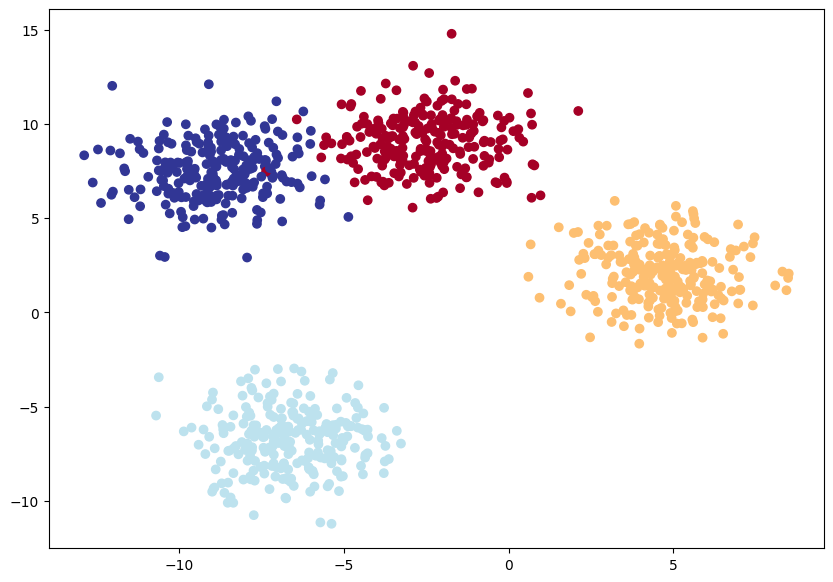

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [3]:
## Spliting data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [4]:
y_test.dtype

torch.int64

In [5]:
## Agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
# Declare multi classification model
import torch 

torch.manual_seed = 42
class MultiClassi(torch.nn.Module):
    def __init__(self, input_feature_num, output_feature_num, hidden_unit_num=8):
        super().__init__()
        self.layer_stack = torch.nn.Sequential(
            torch.nn.Linear(
                in_features=input_feature_num,
                out_features=hidden_unit_num
            ),
            torch.nn.ReLU(),
            torch.nn.Linear(
                in_features=hidden_unit_num,
                out_features=hidden_unit_num
            ),
            torch.nn.ReLU(),
            torch.nn.Linear(
                in_features=hidden_unit_num,
                out_features=output_feature_num
            )
        )

    def forward(self, x):
        return self.layer_stack(x)
    
multiclassi_model = MultiClassi(input_feature_num=2, output_feature_num=4).to(device)

In [28]:
## Select loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=multiclassi_model.parameters(), lr=0.1)

In [29]:
def accuracy_cal(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred))*100

In [30]:
## Move data to device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [31]:
## Test accuracy fuction
with torch.inference_mode():
    y_logits = multiclassi_model(X_test)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    acc = accuracy_cal(y_pred, y_test)

In [32]:
## Training loops
epochs = 100



for epoch in range(epochs):
    multiclassi_model.train()

    # 1. Forward pass
    y_logits = multiclassi_model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Calculate loss and accuracy
    loss = loss_func(y_logits, y_train)
    acc = accuracy_cal(y_pred, y_train)

    # 3. Back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    multiclassi_model.eval()
    with torch.inference_mode():
        # 1. Forward mode
        test_logits = multiclassi_model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # 2. Calculate loss and accuracy
        test_loss = loss_func(test_logits, y_test)
        test_acc = accuracy_cal(test_pred, y_test)

    ## Print log
    if epoch % 10 == 0:
        print(f"Loss: {loss} | Accuracy: {acc}% || Test Loss: {test_loss} | Test Accuracy: {test_acc}")


Loss: 1.4702770709991455 | Accuracy: 24.125% || Test Loss: 1.3850319385528564 | Test Accuracy: 50.5
Loss: 1.014053225517273 | Accuracy: 62.875% || Test Loss: 0.9070044755935669 | Test Accuracy: 69.5
Loss: 0.5073049664497375 | Accuracy: 75.75% || Test Loss: 0.4552163779735565 | Test Accuracy: 78.5
Loss: 0.40704235434532166 | Accuracy: 81.125% || Test Loss: 0.37653204798698425 | Test Accuracy: 82.5
Loss: 0.3761052191257477 | Accuracy: 84.875% || Test Loss: 0.3478188216686249 | Test Accuracy: 89.5
Loss: 0.3343641757965088 | Accuracy: 92.0% || Test Loss: 0.3011414706707001 | Test Accuracy: 94.5
Loss: 0.19748423993587494 | Accuracy: 98.625% || Test Loss: 0.1624498963356018 | Test Accuracy: 99.5
Loss: 0.10161939263343811 | Accuracy: 99.125% || Test Loss: 0.08253692835569382 | Test Accuracy: 99.5
Loss: 0.06967790424823761 | Accuracy: 99.125% || Test Loss: 0.055319905281066895 | Test Accuracy: 99.5
Loss: 0.05571109801530838 | Accuracy: 99.125% || Test Loss: 0.04286259785294533 | Test Accuracy:

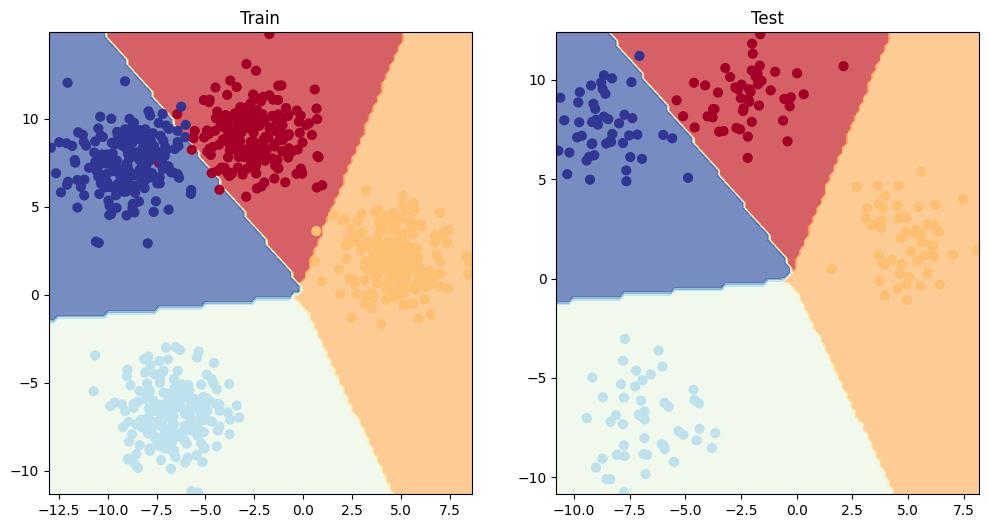

In [33]:
## Visualize prediction
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(multiclassi_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(multiclassi_model, X_test, y_test)